In [55]:
import numpy as np
from itertools import islice
import pandas as pd
import pickle
import csv
import matplotlib.pyplot as plt
import seaborn as sns

# import from scripts
import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
#os.chdir(os.path.abspath("C:\\Users\\ipoch\\Documents\\repos\\isttc\\scripts"))
from calculate_tau import fit_single_exp, fit_single_exp_2d, func_single_exp, func_single_exp_monkey
from calculate_acf import acf_sttc, acf_pearsonr_trial_avg, acf_sttc_trial_avg, acf_sttc_trial_concat
from spike_train_utils import bin_spike_train_fixed_len, get_trials, bin_trials
from cfg_global import project_folder_path
os.chdir(current_wd)

In [2]:
dataset_folder = project_folder_path + 'results\\allen_mice\\dataset\\cut_30min\\'

In [ ]:
csv_data_file = dataset_folder + 'sua_list_constrained.csv'
print(f'Loading file {csv_data_file}')
with open(csv_data_file, newline='') as f:
    reader = csv.reader(f)
    sua_list = list(reader)
print(f'Loaded N units {len(sua_list)}')

In [4]:
with open(dataset_folder + 'trial_dict.pkl', 'rb') as f:
    trial_dict = pickle.load(f)

with open(dataset_folder + 'trial_binned_dict.pkl', 'rb') as f:
    trial_binned_dict = pickle.load(f)

In [5]:
fs = 30000

signal_len = int(30 * 60 * fs)
n_lags = 20
bin_size = 50  # in ms
sttc_dt = int(49 * (fs / 1000))
trial_len = int(n_lags * bin_size * (fs / 1000))

n_trials = 40  # this is fixed based on experimental datasets
m_iterations = 100

#### For 1 unit

In [ ]:
spikes = np.asarray([int(spike) for spike in sua_list[700][8:]])
print(len(spikes))
print(spikes[-1]/fs/60)

In [27]:
trial_dict.keys()

dict_keys(['950913540', '950915005', '950915018'])

In [54]:
for k,v in trial_dict.items():
    print(k)

950913540
950915005
950915018


In [56]:
for k, v in islice(trial_dict.items(), 2):
    print(k)

950913540
950915005


In [44]:
spikes_trials = trial_dict['950915018'][0]
spikes_trials_binned = trial_binned_dict['950915018'][0]

In [ ]:
spikes_trials = get_trials(spikes, signal_len, n_trials, trial_len, verbose_=False)
spikes_trials_binned = bin_trials(spikes_trials, trial_len, int(bin_size*(fs/1000)))

In [45]:
pearson_avg_l, sttc_avg_l, sttc_concat_l = [], [], []
pearson_avg_acf_l, sttc_avg_acf_l, sttc_concat_acf_l = [], [], []
pearson_avg_acf_matrix_l, sttc_avg_acf_matrix_l = [], []

In [46]:
pearsonr_acf_matrix, pearsonr_acf_average = acf_pearsonr_trial_avg(spikes_trials_binned, n_lags, verbose_=False)
fit_popt, fit_pcov, tau, tau_ci, fit_r_squared, explained_var, log_message = fit_single_exp(pearsonr_acf_average,
                                                                          start_idx_=1, exp_fun_=func_single_exp_monkey)
pearson_avg_l.append({'tau':tau,
                      'tau_lower':tau_ci[0],
                      'tau_upper':tau_ci[1],
                      'fit_r_squared': fit_r_squared,
                      'explained_var': explained_var,
                      'popt': fit_popt,
                      'pcov': fit_pcov,
                      'log_message': log_message})
pearson_avg_acf_l.append(pearsonr_acf_average)
pearson_avg_acf_matrix_l.append(pearsonr_acf_matrix)

In [ ]:
pearson_avg_acf_l

In [47]:
sttc_acf_matrix, sttc_acf_average = acf_sttc_trial_avg(spikes_trials, n_lags_=n_lags, lag_shift_=bin_size * (fs / 1000), 
                                                       sttc_dt_=sttc_dt,
                                             zero_padding_len_=int(150 * (fs / 1000)), verbose_=False)
fit_popt, fit_pcov, tau, tau_ci, fit_r_squared, explained_var, log_message = fit_single_exp(sttc_acf_average, start_idx_=1, exp_fun_=func_single_exp_monkey)
sttc_avg_l.append({'tau':tau,
                      'tau_lower':tau_ci[0],
                      'tau_upper':tau_ci[1],
                      'fit_r_squared': fit_r_squared,
                      'explained_var': explained_var,
                      'popt': fit_popt,
                      'pcov': fit_pcov,
                      'log_message': log_message})
sttc_avg_acf_l.append(sttc_acf_average)
sttc_avg_acf_matrix_l.append(sttc_acf_matrix)

In [ ]:
sttc_avg_acf_l

In [48]:
acf_concat = acf_sttc_trial_concat(spikes_trials, n_lags_=n_lags, lag_shift_=bin_size * (fs / 1000), sttc_dt_=sttc_dt,
                                   trial_len_=trial_len,
                                   zero_padding_len_=int(3000 * (fs / 1000)), verbose_=False)
fit_popt, fit_pcov, tau, tau_ci, fit_r_squared, explained_var, log_message = fit_single_exp(acf_concat, start_idx_=1, exp_fun_=func_single_exp_monkey)
sttc_concat_l.append({'tau':tau,
                      'tau_lower':tau_ci[0],
                      'tau_upper':tau_ci[1],
                      'fit_r_squared': fit_r_squared,
                      'explained_var': explained_var,
                      'popt': fit_popt,
                      'pcov': fit_pcov,
                      'log_message': log_message})
sttc_concat_acf_l.append(acf_concat)

In [ ]:
sttc_concat_acf_l[0]

### Plots

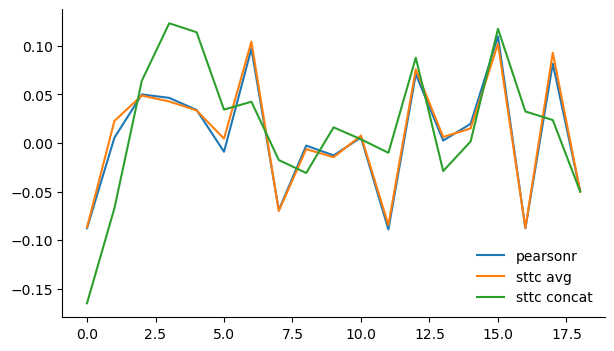

In [49]:
fig, axes = plt.subplots(1,1, figsize=(7, 4))

axes.plot(pearson_avg_acf_l[0][1:], label='pearsonr')
axes.plot(sttc_avg_acf_l[0][1:], label='sttc avg')
axes.plot(sttc_concat_acf_l[0][1:], label='sttc concat')

axes.legend(frameon=False)
sns.despine()

<Axes: >

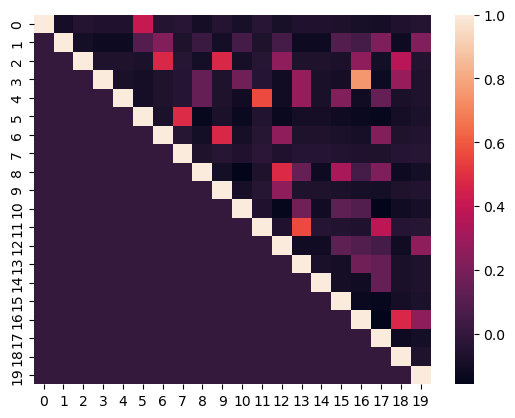

In [50]:
sns.heatmap(pearson_avg_acf_matrix_l[0])

<Axes: >

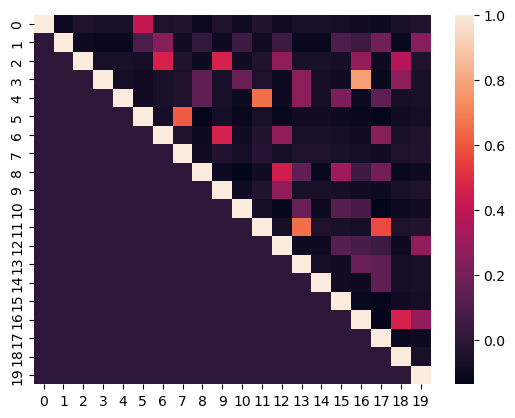

In [51]:
sns.heatmap(sttc_avg_acf_matrix_l[0])